# Calculate explained variance

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
# import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [2]:
info = get_info(sfreq=100)
fwd = create_forward_model(info=info, sampling="ico2")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.8s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.8s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


## Simulate
Next, we simulate two types of data: 
1. Data containing small sources with 15-25 mm in diameter.
2. Data containing large sources with 35-45 mm in diameter.

Note, that for publication-ready inverse solutions you should increase the number of training samples to 100,000.

In [3]:
n_samples = 1000
settings = dict(duration_of_trial=0.25)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)

Simulating data based on sparse patches.


100%|██████████| 1000/1000 [00:12<00:00, 79.93it/s]


## Train individual neural networks

In [4]:
model_type = 'FC'  # can be 'LSTM' or 'ConvDip', too
net = Net(fwd, verbose=True, model_type=model_type)
net.fit(sim, epochs=10)


preprocess data
wrks4
Model: "FC-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FC_0 (TimeDistributed)       (None, None, 200)         12400     
_________________________________________________________________
Drop_0 (Dropout)             (None, None, 200)         0         
_________________________________________________________________
FC_Out (TimeDistributed)     (None, None, 324)         65124     
Total params: 77,524
Trainable params: 77,524
Non-trainable params: 0
_________________________________________________________________
fit model
Epoch 1/10
112/112 [==============================] - 1s 6ms/step - loss: -0.1488 - mae: 0.2324 - val_loss: -0.2258 - val_mae: 0.2069
Epoch 2/10
112/112 [==============================] - 0s 4ms/step - loss: -0.2422 - mae: 0.2018 - val_loss: -0.2687 - val_mae: 0.1745
Epoch 3/10
112/112 [==============================] - 0s 3ms/step - loss: -0.2767 - 

c:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


KeyboardInterrupt: 

In [14]:
n_samples = 2
settings = dict(duration_of_trial=0.25, target_snr=1e99)
sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
net.predict(sim_test)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 58.83it/s]
c:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


True eeg shape:  (2, 61, 25)
est eeg shape:  (2, 61, 25)
Residual Variance(s): [3.11, 1.65] [%]


[<SourceEstimate | 324 vertices, subject : fsaverage, tmin : 0.0 (ms), tmax : 240.0 (ms), tstep : 10.0 (ms), data shape : (324, 25), ~34 kB>,
 <SourceEstimate | 324 vertices, subject : fsaverage, tmin : 0.0 (ms), tmax : 240.0 (ms), tstep : 10.0 (ms), data shape : (324, 25), ~34 kB>]

# Eval

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 83.24it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


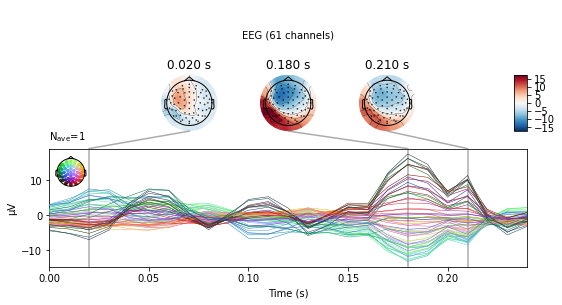

c:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


No projector specified for this dataset. Please consider the method self.add_proj.


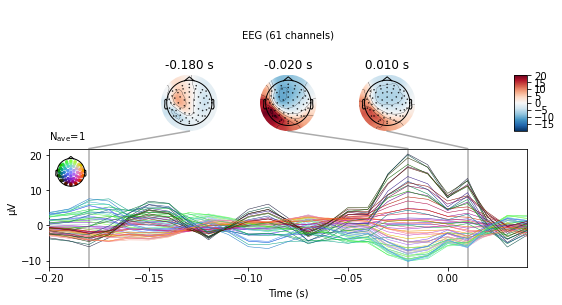

In [25]:
from esinet.util import get_eeg_from_source
# Simulate
n_samples = 2
settings = dict(duration_of_trial=0.25)
sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
# Plot Ground Truth
idx = 0
evoked = sim_test.eeg_data[idx].average()
stc = sim_test.source_data[idx]
evoked.plot_joint()

# Plot estimate
stc_hat = net.predict(evoked)[0]
stc.plot(**plot_params, brain_kwargs=dict(title="Ground Truth"))
stc_hat.plot(**plot_params, brain_kwargs=dict(title="Net"))

evoked_hat = get_eeg_from_source(stc_hat, fwd, info)
evoked_hat.plot_joint()
print()

In [35]:
import numpy as np
M = evoked.data
M_hat = evoked_hat.data
# var_exp = 100 * np.linalg.norm( M_hat ) / np.linalg.norm(M)
# var_exp = 100 *  np.linalg.norm( M-M_hat ) / np.linalg.norm(M)
var_exp = 100 *  np.sum( (M-M_hat)**2 ) / np.sum(M**2)

var_exp

7.709635699352937

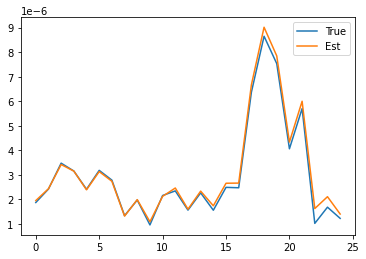

In [36]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(M.std(axis=0), label="True")
plt.plot(M_hat.std(axis=0), label="Est")
plt.legend()

In [17]:
M.shape

(61, 25)